# <span style="color:blue"> <center>Case Geofusion - Classificadores</center></span>
## **<center>2. Classificar o potencial de cada bairro como Alto, Médio ou Baixo</center>**
<center>Solução proposta por Lucas Victor Silva Pereira</center>

O objetivo neste notebook é classificar os bairros da cidade de São Paulo em uma das três classes: *Baixo, Médio ou Alto*. Essas classes se referem aos bairros serem ou não  bons locais para a empresa investir. Como a empresa forneceu dados rotulados (aqueles que os potenciais já são conhecidos) dos bairros da cidade do Rio de Janeiro, eles serão utilizados para treinar alguns modelos. Com os modelos treinados a base de dados com bairros da cidade de São Paulo será classificada.

Os classificadores apresentados aqui são: **Regressão Logística**, **KNN**, **SVM**, **Naive Bayes**, dois algoritmos baseados em **árvore de decisão**.

Observe que a variável *faturamento* é importante (provavelmente a mais importante) para determinar o potencial dos bairros. Por isso, a regressão proposta no *item 1 do case* (regressão linear), será usada para predizer os prováveis faturamentos que a empresa teria caso investisse em cada um dos bairros da cidade de São Paulo.

Ordenação do Notebook:

1. Tratamento dos dados;
2. Regressão Linear;
3. Predição dos valores de faturamento para os bairros da cidade de São Paulo com base no regressor desenvolvido em 2;
3. Classificadores.

In [6]:
#Required Libraries 
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns
from sklearn import metrics #from sklearn.metrics import accuracy_score #mean_squared_error, r2_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression #LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


from mlxtend.plotting import plot_decision_regions

### **<center>Tratamento dos Dados</center>**

In [7]:
#Read and process the database
url = 'dataset/DadosDeliciousFood.csv'

dfFoodB = pd.read_csv(url, encoding='utf-8')
dfFoodB = dfFoodB.drop_duplicates()
if (dfFoodB.duplicated('codigo').sum() > 0):
    print("ALERT: DATA CONFLICT. Check possible solutions with data engineers.")
dfFoodB = dfFoodB.replace('-', np.nan)
dfFoodB = dfFoodB.replace('?', np.nan)

mask = ((dfFoodB['popAte9'] == 0) & (dfFoodB['popDe10a14'] == 0) & (dfFoodB['popDe15a19'] == 0) & \
        (dfFoodB['popDe20a24'] == 0) & (dfFoodB['popDe25a34'] == 0) & (dfFoodB['popDe35a49'] == 0) & \
        (dfFoodB['popDe50a59'] == 0) & (dfFoodB['popMaisDe60'] == 0)) | \
       ((dfFoodB['domiciliosA1'] == 0) & (dfFoodB['domiciliosA2'] == 0) & (dfFoodB['domiciliosB1'] == 0) & \
        (dfFoodB['domiciliosB2'] == 0) & (dfFoodB['domiciliosC1'] == 0) & (dfFoodB['domiciliosC2'] == 0) & \
        (dfFoodB['domiciliosD'] == 0) & (dfFoodB['domiciliosE'] == 0)) |\
       (dfFoodB['população'] != (dfFoodB['popAte9'] + dfFoodB['popDe10a14'] + dfFoodB['popDe15a19'] + \
                                 dfFoodB['popDe20a24'] + dfFoodB['popDe25a34'] + dfFoodB['popDe35a49'] + \
                                 dfFoodB['popDe50a59'] + dfFoodB['popMaisDe60'])) |\
       ((dfFoodB['rendaMedia'] == 0) & (dfFoodB['faturamento'] == 0))
dfFoodB = dfFoodB.loc[~mask]

dfFoodBRJ = dfFoodB.loc[dfFoodB['estado'] == "RJ"]

dfFoodBRJ = dfFoodBRJ.dropna(axis='rows') #remove rows NaN/null

dfFoodBRJ = dfFoodBRJ.drop(['codigo','nome','cidade','estado','população'], axis=1)

fFoodBRJTree = dfFoodBRJ.copy()

#Turns the potential class that is nominal into numbers 
classes = np.unique(dfFoodBRJ['potencial']) # Stores the name of the classes 
#classes = classes[::-1].sort()
for i in classes:
    convert = False;
    if(i == 'Baixo'):
        number = 0
        convert = True;
    elif(i == 'Médio'):
        number = 1
        convert = True;
    elif(i == 'Alto'):
        number = 2
        convert = True;
    if(convert):
        dfFoodBRJ['potencial'] = dfFoodBRJ['potencial'].replace(i, number) # substitui cada valor da classe por number
    #number = number - 1
#'''
classesNum = np.unique(dfFoodBRJ['potencial']) # Stores the name of the classes 

dfFoodBRJ = dfFoodBRJ.astype('float')

dfFoodBRJ.iloc[:,0:16] = dfFoodBRJ.iloc[:,0:16] / 100
dfFoodBRJ['rendaMedia'] = np.log(dfFoodBRJ['rendaMedia'])
dfFoodBRJ['faturamento'] = dfFoodBRJ['faturamento'] / 10000

mask = (dfFoodBRJ['rendaMedia'] >= 11)
dfFoodBRJ = dfFoodBRJ.loc[~mask]

In [8]:
N = (dfFoodBRJ['potencial'].astype('int64') == 2).sum()
cl = np.unique(dfFoodBRJ['potencial'])
X = np.array(dfFoodBRJ, dtype=float)
dfFoodBRJNew = []
cls = np.array(dfFoodBRJ[dfFoodBRJ.columns[-1]])
for i in np.arange(0, len(cl)):
    a = np.argwhere(cls == cl[i])
    inds = np.random.choice(a[:,0],N,replace=False) # select indexes in the data at random 
    dfFoodBRJNew.append(X[inds,:])
dfFoodBRJNew = np.array(dfFoodBRJNew)
dfFoodBRJNew = dfFoodBRJNew.reshape(dfFoodBRJNew.shape[0]*dfFoodBRJNew.shape[1], dfFoodBRJNew.shape[2])
np.random.shuffle(dfFoodBRJNew)

### **<center>Regressão Linear</center>**

In [9]:
# Standardization 
scaler = StandardScaler().fit(dfFoodBRJNew[:,:-2])
dfFoodBRJNewX = scaler.transform(dfFoodBRJNew[:,:-2])

#PCA - 4 main components 
pca4C = PCA(n_components=4)
dfFoodBRJNewX = pca4C.fit_transform(dfFoodBRJNewX)

print("Variância explicada:", pca4C.explained_variance_ratio_)
print("Variância Explicada pelos 4 Primeiros Componentes:", pca4C.explained_variance_ratio_.sum())

lm = LinearRegression().fit(dfFoodBRJNewX, dfFoodBRJNew[:,-2])

Variância explicada: [0.71051153 0.19514415 0.03977654 0.02450226]
Variância Explicada pelos 4 Primeiros Componentes: 0.9699344725810445


### **<center>Estimando o valor da variável Faturamento para os bairros da cidade de São Paulo</center>**

In [10]:
dfFoodBSP = dfFoodB.loc[dfFoodB['estado'] == "SP"]

dfFoodBSP = dfFoodBSP.drop(['faturamento','potencial'], axis=1)
dfFoodBSP = dfFoodBSP.dropna(axis='rows') #remove rows NaN/null
dfFoodBSP = dfFoodBSP.drop(['codigo','nome','cidade','estado','população'], axis=1)
dfFoodBSP = dfFoodBSP.astype('float')

df_FoodBSP = dfFoodBSP.copy()

dfFoodBSP.iloc[:,0:16] = dfFoodBSP.iloc[:,0:16] / 100
dfFoodBSP['rendaMedia'] = np.log(dfFoodBSP['rendaMedia'])

scaler = StandardScaler().fit(dfFoodBSP)
dfFoodBSPR = scaler.transform(dfFoodBSP)

dfFoodBSPR = pca4C.fit_transform(dfFoodBSPR)

y_pred_F_SP = lm.predict(dfFoodBSPR)


df_FoodBSP['faturamento'] = (y_pred_F_SP*10000)

### **<center>PCA</center>**

In [11]:
# Standardization 
scaler = StandardScaler().fit(dfFoodBRJNew[:,:-1])
dfFoodBRJNewX = scaler.transform(dfFoodBRJNew[:,:-1])

#PCA - 2 main components 
pca2C = PCA(n_components=2)
pca2C.fit(dfFoodBRJNewX)
pca2C_result = pca2C.fit_transform(dfFoodBRJNewX)

print("Variância Explicada pelos 2 Primeiros Componentes:", pca2C.explained_variance_ratio_.sum())

#PCA - 4 main components
pca4C.fit(dfFoodBRJNewX)
pca4C_result = pca2C.fit_transform(dfFoodBRJNewX)

print("Variância Explicada pelos 4 Primeiros Componentes:", pca4C.explained_variance_ratio_.sum())
print("Variância explicada por cada uma das 4 Componentes:", pca4C.explained_variance_ratio_)

Variância Explicada pelos 2 Primeiros Componentes: 0.9079038150441907
Variância Explicada pelos 4 Primeiros Componentes: 0.9692363842625842
Variância explicada por cada uma das 4 Componentes: [0.6732651  0.23463871 0.0381557  0.02317687]


### **<center>Separação da base de dados em treino e teste para TODOS os classifcadores</center>**

In [12]:
#x_train, x_test, y_train, y_test = train_test_split(dfFoodBRJNewX, dfFoodBRJNew[:,-1], test_size = 0.2, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(dfFoodBRJNewX, dfFoodBRJNew[:,-1], test_size = 0.2, random_state = 42)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train2C = pca2C.fit_transform(x_train)
x_test2C = pca2C.transform(x_test)

x_train4C = pca4C.fit_transform(x_train)
x_test4C = pca4C.transform(x_test)

Com a Base de dados *<font style="font-family: monaco">dfFoodBSP</font>* preparada, os campos abaixo implementam e treinam os *classificadores* utilizando os dados da base *<font style="font-family: monaco">dfFoodBRJ</font>*. Com os modelos treinados a base *<font style="font-family: monaco">dfFoodBSP</font>* é classificada.<br>

# **<center>Classificadores</center>**

Com exceção aos classificadores baseados em árvore de decisão, todos os outros serão inicialmente treinados utilizando apenas os dois primeiros componentes principais da **PCA**. Isso é feito para que seja possível plotar as regiões de divisão que os classificadores propõem. Contudo, assim como foi feito na *regressão linear* os classificares utilizados para classificar a base *<font style="font-family: monaco">dfFoodBSP</font>* utilizam as 4 primeiras componentes principais do PCA.

### **<center>1. Regressão Logística</center>**

A regressão logística será o único classificador linear proposto para a classificação dos bairros de São Paulo.

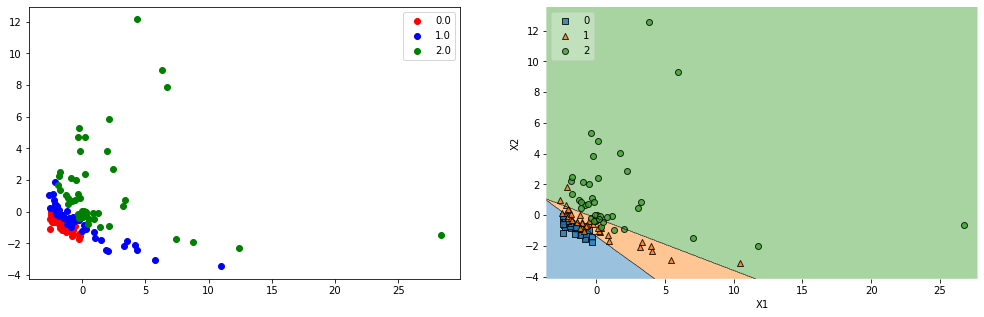

In [13]:
# mostra os dados e colori de acordo com as classes
colors = ['red', 'blue', 'green']
class_labels = np.unique(dfFoodBRJNew[:,-1])

plt.figure(figsize=(17,5))
plt.subplot(1, 2, 1)

aux = 0
for c in class_labels:
    nodes = np.where(dfFoodBRJNew[:,-1] == c)
    plt.scatter(pca2C_result[nodes,0], pca2C_result[nodes,1], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()

y_train_plot = y_train.astype(np.int_)

plt.subplot(1, 2, 2)
modelLG = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 2000)
modelLG.fit(x_train2C, y_train)
plot_decision_regions(x_train2C, y_train_plot, clf=modelLG, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show(True)

In [14]:
modelLG = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
modelLG.fit(x_train4C, y_train)

y_pred = modelLG.predict(x_test4C)
print('Acurácia: ', modelLG.score(x_test4C, y_test))

Acurácia:  0.8620689655172413


### **<center>2. Classificador Naive Bayes</center>**

Como o problema é multiclasses o classificador bayesiano utiliza funções gaussianas, portanto, as regiões de classificação serão Elipsoidais.

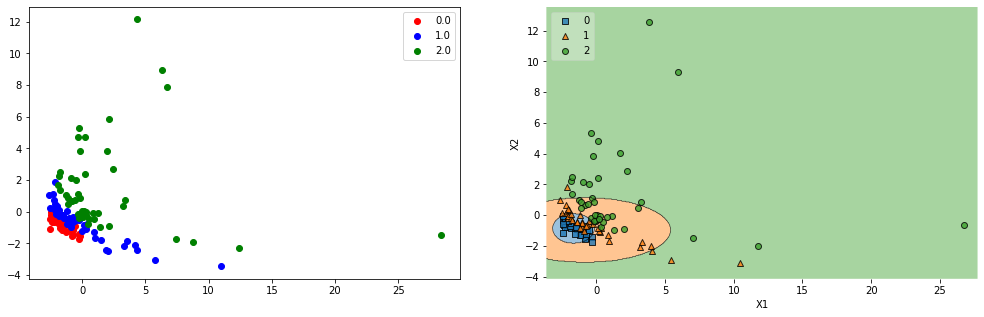

In [15]:
plt.figure(figsize=(17,5))
plt.subplot(1, 2, 1)

aux = 0
for c in class_labels:
    nodes = np.where(dfFoodBRJNew[:,-1] == c)
    plt.scatter(pca2C_result[nodes,0], pca2C_result[nodes,1], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()

plt.subplot(1, 2, 2)
modelGNB = GaussianNB()
modelGNB.fit(x_train2C, y_train)
plot_decision_regions(x_train2C, y_train_plot, clf=modelGNB, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show(True)

In [16]:
modelGNB = GaussianNB()
modelGNB.fit(x_train4C, y_train)

y_pred = modelGNB.predict(x_test4C)
print('Accuracy: ', modelGNB.score(x_test4C, y_test))

Accuracy:  0.6551724137931034


### **<center>3. KNN</center>**

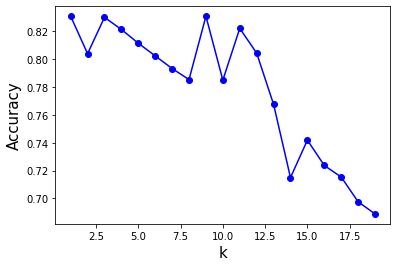

Melhor k: 1


In [17]:
nkf = 5 #number of folds
vk = [] # armazena os valores de k
vscore = []
for k in range(1, 20):
    modelKNN = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # realiza a validação cruzada
    cv = cross_validate(modelKNN, x_train2C, y_train, cv=nkf)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean()) 
    vk.append(k)

plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show(True)
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)

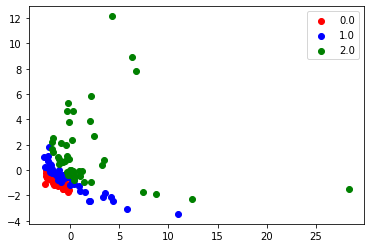

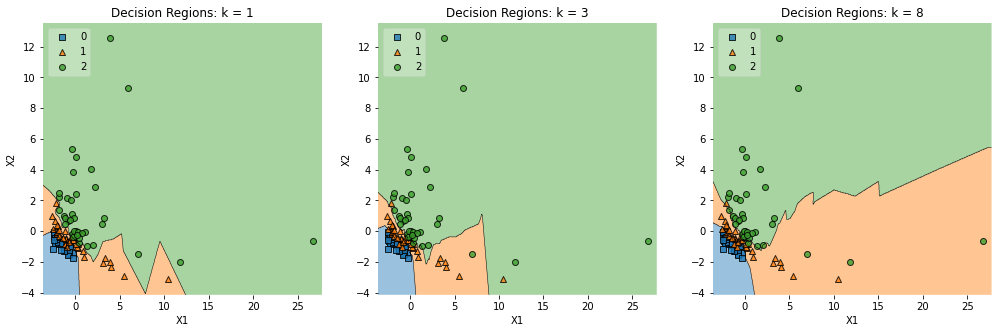

In [18]:
aux = 0
for c in class_labels:
    nodes = np.where(dfFoodBRJNew[:,-1] == c)
    plt.scatter(pca2C_result[nodes,0], pca2C_result[nodes,1], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()
plt.show()

if(best_k != 1):
    vk = [1,best_k,(best_k+5)]
else:
    vk = [best_k,(best_k+2),(best_k+7)]
    
plt.figure(figsize=(17,5))
aux = 1
for k in vk:
    # Training a classifier
    modelKNN = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    modelKNN.fit(x_train2C, y_train)
    # Plotting decision regions
    plt.subplot(1, 3, aux)
    plot_decision_regions(x_train2C, y_train_plot, clf=modelKNN, legend=2)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Regions: k = '+str(k))
    aux += 1
plt.show(True)

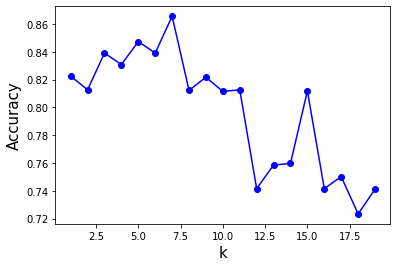

Melhor k: 7


In [19]:
vk = [] # armazena os valores de k
vscore = []
for k in range(1, 20):
    modelKNN = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # realiza a validação cruzada
    cv = cross_validate(modelKNN, x_train4C, y_train, cv=nkf)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean()) 
    vk.append(k)

plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show(True)
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)

In [20]:
modelKNN = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
modelKNN.fit(x_train4C, y_train)
y_pred = modelKNN.predict(x_test4C)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'), '\n')

print("Matriz de confusão:\n", metrics.confusion_matrix(y_test, y_pred, labels=range(len(classes))))

Accuracy: 0.9310344827586207
Precision: 0.9310344827586207
Recall: 0.919047619047619 

Matriz de confusão:
 [[12  0  0]
 [ 1  9  0]
 [ 0  1  6]]


### **<center>4. SVM</center>**

In [21]:
param_grid = {'C': [1e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.15, 0.2]}

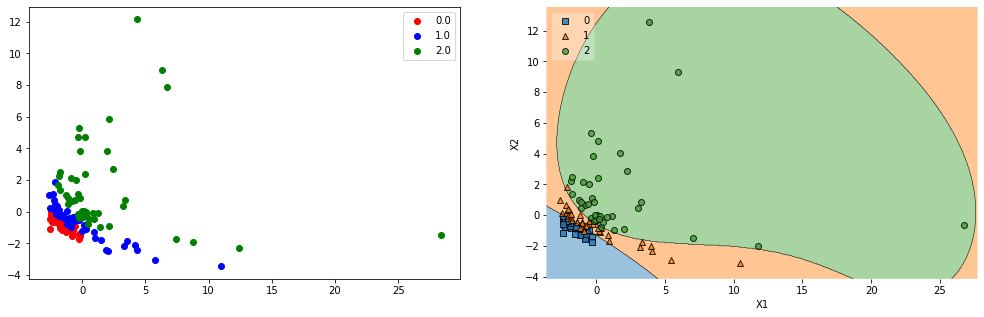

Accuracy SVM with 2 PC: 0.9310344827586207


In [22]:
plt.figure(figsize=(17,5))
plt.subplot(1, 2, 1)

aux = 0
for c in class_labels:
    nodes = np.where(dfFoodBRJNew[:,-1] == c)
    plt.scatter(pca2C_result[nodes,0], pca2C_result[nodes,1], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()

plt.subplot(1, 2, 2)

modelSVM = GridSearchCV(SVC(kernel='rbf'), param_grid)
modelSVM = modelSVM.fit(x_train2C, y_train)
# Plotting decision regions
plot_decision_regions(x_train2C, y_train_plot, clf=modelSVM, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show(True)

print("Accuracy SVM with 2 PC:", metrics.accuracy_score(y_test, y_pred))

In [23]:
# Training an SVM classification model 
print("Fitting the classifier to the training set")
t0 = time()
modelSVM = GridSearchCV(SVC(kernel='rbf'), param_grid)
modelSVM = modelSVM.fit(x_train4C, y_train)
print("done in {0:.3f}s".format(time() - t0))
print("Best estimator found by grid search:")
print(modelSVM.best_estimator_)

Fitting the classifier to the training set
done in 0.609s
Best estimator found by grid search:
SVC(C=100000.0, gamma=0.0001)


In [24]:
print("Prediction of potential classes in the test set ")
t0 = time()
y_pred = modelSVM.predict(x_test4C)

print("done in {0:.3f}s".format(time() - t0))

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

Prediction of potential classes in the test set 
done in 0.001s
Accuracy: 0.896551724137931
Precision: 0.896551724137931
Recall: 0.8857142857142857


In [25]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(len(classes))))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92        12
         1.0       0.89      0.80      0.84        10
         2.0       1.00      0.86      0.92         7

    accuracy                           0.90        29
   macro avg       0.92      0.89      0.90        29
weighted avg       0.90      0.90      0.90        29

[[12  0  0]
 [ 2  8  0]
 [ 0  1  6]]


### **<center>5. Classificadores Baseados em Árvores</center>**

Observe que os métodos de árvore de decisão não utilizam medidas de distância para classificar. Por isso, não é necessário normalizar/padronizar os dados. Além disso, as árvores de decisão não possuem parâmetros treináveis (apenas hiperparâmetros, assim como o KNN). portanto, a *<font style="font-family: monaco">maldição da dimensionalidade</font>* não afeta os modelos.

#### <center>5.1 Árvores de Decisão</center>

In [26]:
if isinstance(fFoodBRJTree, pd.DataFrame):
    fFoodBRJTreeNP = fFoodBRJTree.to_numpy()
    fFoodBRJTreeY = fFoodBRJTreeNP[:,-1]
    fFoodBRJTreeNP = fFoodBRJTreeNP[:,0:-1]

#print(fFoodBRJTreeNP)
    
x_train, x_test, y_train, y_test = train_test_split(fFoodBRJTreeNP, fFoodBRJTreeY, test_size = 0.2, shuffle=True)

# Creates the model using the Gini criterion 
modelTreeG = DecisionTreeClassifier(criterion = 'gini', random_state = 101)
modelTreeG.fit(x_train, y_train)
y_pred = modelTreeG.predict(x_test)

print('Accuracy:', metrics.accuracy_score(y_pred, y_test))
metrics.confusion_matrix(y_pred, y_test)

pd.crosstab(y_pred, y_test, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8709677419354839


Predicted,Alto,Baixo,Médio,All
True,,,,
Alto,12,0,3,15
Baixo,0,10,0,10
Médio,0,1,5,6
All,12,11,8,31


In [27]:
# Creates the model using the Gini criterion 
modelTreeE = DecisionTreeClassifier(criterion = 'entropy', random_state = 101)
modelTreeE.fit(x_train, y_train)
y_pred = modelTreeE.predict(x_test)

print('Accuracy:', metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.9032258064516129


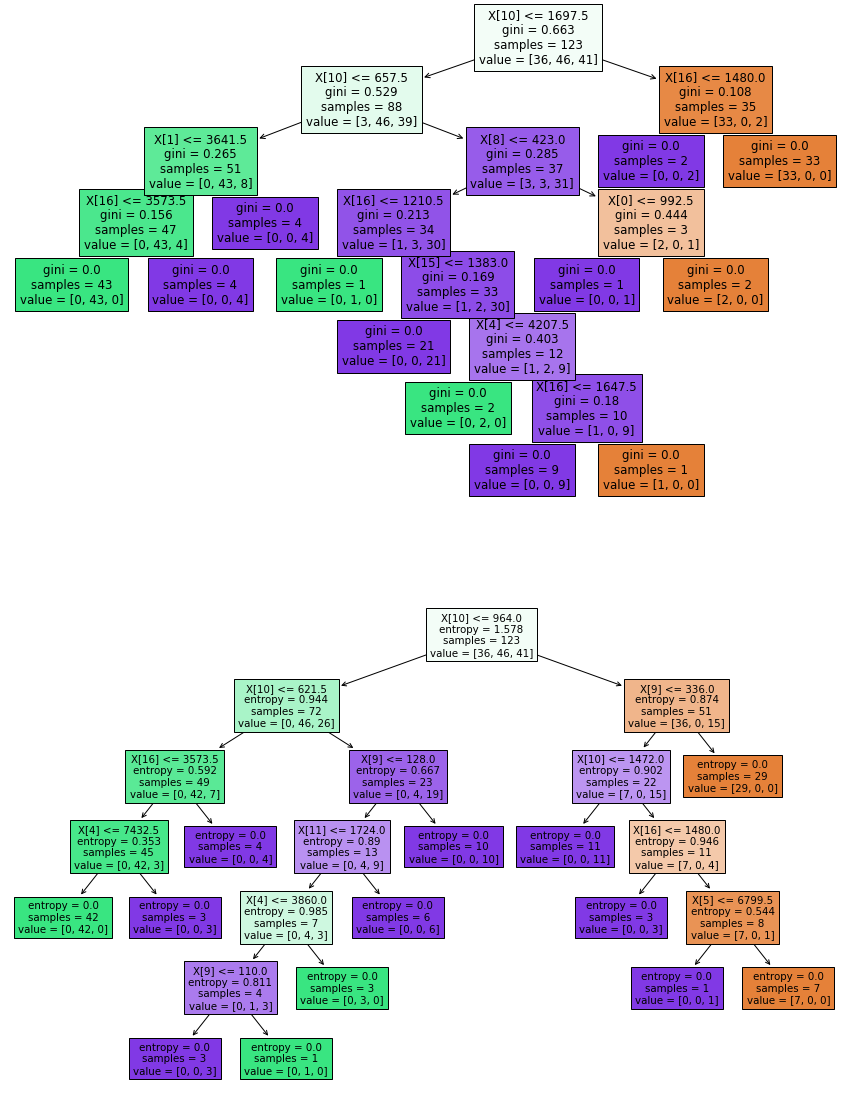

In [28]:
plt.figure(figsize=(15,20))
plt.subplot(2, 1, 1)
plot_tree(modelTreeG.fit(x_train,y_train),filled=True)
plt.subplot(2, 1, 2)
plot_tree(modelTreeE.fit(x_train,y_train),filled=True)
plt.show(True)

#### <center>5.2. RandomForest</center>

In [29]:
modelRF=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
modelRF.fit(x_train,y_train)

y_pred = modelRF.predict(x_test)
print('Accuracy:', metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.967741935483871


Number of Estimators: 1 Accuracy: 0.7741935483870968
Number of Estimators: 11 Accuracy: 0.9354838709677419
Number of Estimators: 21 Accuracy: 1.0
Number of Estimators: 31 Accuracy: 0.967741935483871
Number of Estimators: 41 Accuracy: 0.967741935483871
Number of Estimators: 51 Accuracy: 0.967741935483871
Number of Estimators: 61 Accuracy: 0.967741935483871
Number of Estimators: 71 Accuracy: 0.967741935483871
Number of Estimators: 81 Accuracy: 0.9354838709677419
Number of Estimators: 91 Accuracy: 0.967741935483871
Melhor n: 21  com acurácia: 1.0


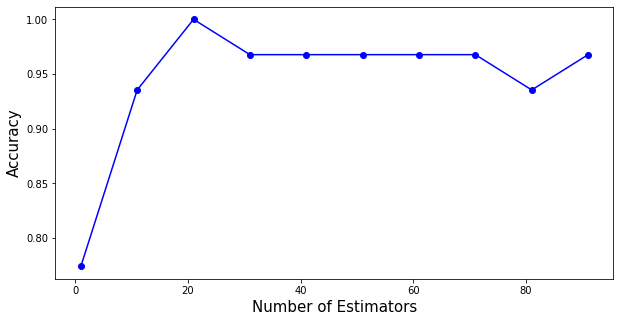

In [30]:
vscore = []
vn = []
for n in range(1,100,10):
    modelRF = RandomForestClassifier(n_estimators=n)
    modelRF.fit(x_train,y_train)
    y_pred = modelRF.predict(x_test) 
    score = metrics.accuracy_score(y_pred, y_test)
    print('Number of Estimators:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

In [31]:
print('Accuracy:', metrics.accuracy_score(y_pred, y_test))
print('F1 score:', metrics.f1_score(y_test, y_pred, average="macro"))
print('Precision:', metrics.precision_score(y_test, y_pred, average="macro"))
print('Recall:', metrics.recall_score(y_test, y_pred, average="macro"))
print('\n clasification report:\n', metrics.classification_report(y_test, y_pred))

metrics.confusion_matrix(y_pred, y_test)
pd.crosstab(y_pred, y_test, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.967741935483871
F1 score: 0.9644444444444445
Precision: 0.9743589743589745
Recall: 0.9583333333333334

 clasification report:
               precision    recall  f1-score   support

        Alto       0.92      1.00      0.96        12
       Baixo       1.00      1.00      1.00        11
       Médio       1.00      0.88      0.93         8

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.96        31
weighted avg       0.97      0.97      0.97        31



Predicted,Alto,Baixo,Médio,All
True,,,,
Alto,12,0,1,13
Baixo,0,11,0,11
Médio,0,0,7,7
All,12,11,8,31


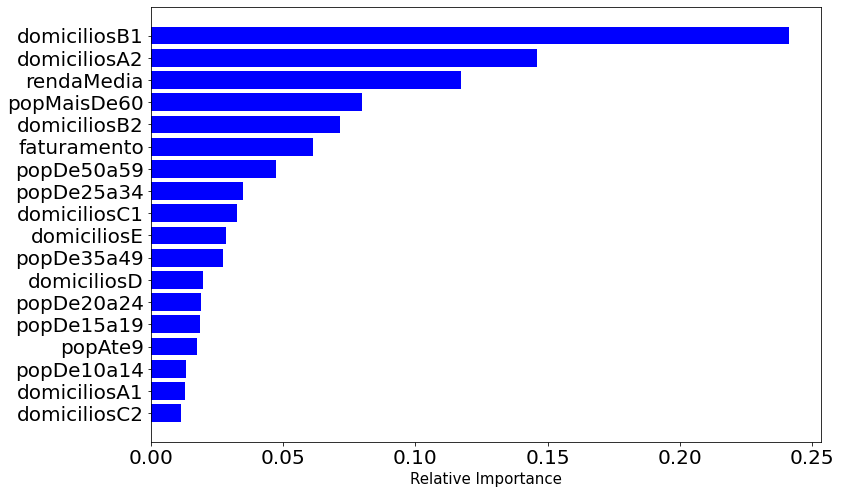

In [32]:
features_names = fFoodBRJTree.columns
importances = modelRF.feature_importances_
indices = np.argsort(importances)
lmeas_order = []
for i in indices:
    lmeas_order.append(features_names[i])
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), lmeas_order, fontsize=15)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

## **<center>Classificando os bairros da cidade de *São Paulo*</center>**

In [33]:
dfFoodBSPR = df_FoodBSP.copy()
dfFoodBSPR.iloc[:,0:16] = dfFoodBSPR.iloc[:,0:16] / 100
dfFoodBSPR['rendaMedia'] = np.log(dfFoodBSPR['rendaMedia'])
dfFoodBSPR['faturamento'] = dfFoodBSPR['faturamento'] / 10000

scaler = StandardScaler().fit(dfFoodBSPR)
dfFoodBSPR = scaler.transform(dfFoodBSPR)

dfFoodBSPR = pca4C.fit_transform(dfFoodBSPR)

y_pred_LG = modelLG.predict(dfFoodBSPR)
y_pred_GNB = modelGNB.predict(dfFoodBSPR)
y_pred_KNN = modelKNN.predict(dfFoodBSPR)
y_pred_SVM = modelSVM.predict(dfFoodBSPR)

y_pred_TG = modelTreeG.predict(df_FoodBSP)
y_pred_TE = modelTreeE.predict(df_FoodBSP)
y_pred_RF = modelRF.predict(df_FoodBSP)

In [34]:
print("Result of the Classification by 'potential' of each neighborhood in São Paulo. (Low Medium High):")
cl = np.unique(y_pred_LG)
ncl = np.zeros(len(cl)) #stores the number of elements in each class 
for i in np.arange(0, len(cl)):
    a = y_pred_LG == cl[i]
    ncl[i] = len(y_pred_LG[a])
print(f'    LOGISTIC REGRESSION: {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')

ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = y_pred_GNB == cl[i]
    ncl[i] = len(y_pred_GNB[a])
print(f'    Naive Bayse (Gauss): {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')

ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = y_pred_KNN == cl[i]
    ncl[i] = len(y_pred_KNN[a])
print(f'                    KNN: {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')

ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = y_pred_SVM == cl[i]
    ncl[i] = len(y_pred_SVM[a])
print(f'                    SVM: {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')


cl = np.unique(y_pred_TG)
ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = y_pred_TG == cl[i]
    ncl[i] = len(y_pred_TG[a])
print(f'   DECISION TREE (GINI): {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')

ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = y_pred_TE == cl[i]
    ncl[i] = len(y_pred_TE[a])
print(f'DECISION TREE (ENTROPY): {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')

ncl = np.zeros(len(cl))
for i in np.arange(0, len(cl)):
    a = y_pred_RF == cl[i]
    ncl[i] = len(y_pred_RF[a])
print(f'          RANDOM FOREST: {int(ncl[1])}, {int(ncl[2])}, {int(ncl[0])}')

Result of the Classification by 'potential' of each neighborhood in São Paulo. (Low Medium High):
    LOGISTIC REGRESSION: 44, 153, 96
    Naive Bayse (Gauss): 164, 98, 31
                    KNN: 91, 98, 104
                    SVM: 29, 147, 117
   DECISION TREE (GINI): 54, 80, 159
DECISION TREE (ENTROPY): 38, 90, 165
          RANDOM FOREST: 48, 105, 140


In [35]:
df_y_pred_KNN = pd.DataFrame(y_pred_KNN, columns = ['potencial'])
df_y_pred_KNN.astype('int64')
df_y_pred_SVM = pd.DataFrame(y_pred_SVM, columns = ['potencial'])
df_y_pred_SVM.astype('int64')
df_y_pred_TG = pd.DataFrame(y_pred_TG, columns = ['potencial'])
df_y_pred_TE = pd.DataFrame(y_pred_TE, columns = ['potencial'])
df_y_pred_RF = pd.DataFrame(y_pred_RF, columns = ['potencial'])

mask_SVM = (df_y_pred_SVM['potencial'] == 2)
mask_KNN = (df_y_pred_KNN['potencial'] == 2)
mask_TG = (df_y_pred_TG['potencial'] == 'Alto')
mask_TE = (df_y_pred_TE['potencial'] == 'Alto')
mask_RF = (df_y_pred_RF['potencial'] == 'Alto')

mask_sum = ((mask_KNN == True) & (mask_SVM == True))
print(f"Nº of neighborhoods with HIGH potential ('KNN', 'SVM'): {mask_sum.sum()}")

mask_sum = ((mask_TG == True) & (mask_TE == True) & (mask_RF == True))
print(f"Nº of neighborhoods with HIGH potential ('DT-GINI', 'DT-ENTROPY', 'RF'): {mask_sum.sum()}")

mask_sum = ((mask_KNN == True) & (mask_TG == True) & (mask_TE == True) & (mask_RF == True))
print(f"Nº of neighborhoods with HIGH potential ('KNN', 'DT-GINI', 'DT-ENTROPY', 'RF'): {mask_sum.sum()}")

mask_sum = ((mask_SVM == True) & (mask_TG == True) & (mask_TE == True) & (mask_RF == True))
print(f"Nº of neighborhoods with HIGH potential ('SVM', 'DT-GINI', 'DT-ENTROPY', 'RF'): {mask_sum.sum()}")

mask_sum = ((mask_KNN == True) & (mask_SVM == True) & (mask_TG == True) & (mask_TE == True) & (mask_RF == True))
print(f"Nº of neighborhoods with HIGH potential ('KNN', 'SVM', 'DT-GINI', 'DT-ENTROPY', 'RF'): {mask_sum.sum()}")

df_FoodBSPClf = df_FoodBSP.copy()

df_FoodBSPClf['potencial'] = mask_sum.tolist()
df_FoodBSPClf['potencial'] = df_FoodBSPClf['potencial'].replace(True, 2)

mask_KNN = ((df_y_pred_KNN['potencial'] == 1) | (df_y_pred_KNN['potencial'] == 2))
mask_SVM = ((df_y_pred_SVM['potencial'] == 1) | (df_y_pred_SVM['potencial'] == 2))
mask_TG = ((df_y_pred_TG['potencial'] == 'Médio') | (df_y_pred_TG['potencial'] == 'Alto'))
mask_TE = ((df_y_pred_TE['potencial'] == 'Médio') | (df_y_pred_TE['potencial'] == 'Alto'))
mask_RF = ((df_y_pred_RF['potencial'] == 'Médio') | (df_y_pred_RF['potencial'] == 'Alto'))

mask_sum = ((mask_KNN == True) & (mask_SVM == True) & (mask_TG == True) & (mask_TE == True) & (mask_RF == True))
print(f"Nº of neighborhoods with MEDIUM and HIGH potential ('KNN', 'SVM', 'DT-GINI', 'DT-ENTROPY', 'RF'): {mask_sum.sum()}")

print("df_FoodBSPClf:\n", df_FoodBSPClf.head(3))

Nº of neighborhoods with HIGH potential ('KNN', 'SVM'): 96
Nº of neighborhoods with HIGH potential ('DT-GINI', 'DT-ENTROPY', 'RF'): 140
Nº of neighborhoods with HIGH potential ('KNN', 'DT-GINI', 'DT-ENTROPY', 'RF'): 94
Nº of neighborhoods with HIGH potential ('SVM', 'DT-GINI', 'DT-ENTROPY', 'RF'): 108
Nº of neighborhoods with HIGH potential ('KNN', 'SVM', 'DT-GINI', 'DT-ENTROPY', 'RF'): 93
Nº of neighborhoods with MEDIUM and HIGH potential ('KNN', 'SVM', 'DT-GINI', 'DT-ENTROPY', 'RF'): 156
df_FoodBSPClf:
      popAte9  popDe10a14  popDe15a19  popDe20a24  popDe25a34  popDe35a49  \
160  12668.0      6853.0      9836.0      7487.0     14535.0     21549.0   
161   2297.0      1017.0      2096.0      2197.0      5341.0      7281.0   
162  15070.0      7343.0     10631.0      8657.0     17749.0     23364.0   

     popDe50a59  popMaisDe60  domiciliosA1  domiciliosA2  domiciliosB1  \
160     10598.0      10508.0           0.0         253.0        2197.0   
161      4917.0       7645.0        